# Case study for Oetelshofen Surface Mine - Spectral analysis
This notebook is part of a series of notebooks for a case study of the Oetelshofen Surface Mine. In this notebook, we look at the various spectral bands available from the SENTINEL2_L1C data collection. 

## Configuration and imports

In [1]:
from sentinelhub import SHConfig

config = SHConfig("sentinel-hub-dida-testing")

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

In [2]:
import datetime
import os

import yaml
import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

from amoki.config import DATA_DIR, REFERENCES_DIR
from amoki.utilities.sentinelhub_utils import plot_image

## Setting area of interest
The bounding box for the Oetelshofen surface mine (one of the biggest open mines in Germany) in `WGS84` coordinate system is approximately `[7.0267, 51.2328, 7.0526, 51.2486]` (longitude and latitude coordinates of lower left and upper right corners). You can get the bbox for a different area at the [bboxfinder](http://bboxfinder.com/) website.

In [3]:
oetelshofen_coords_wgs84 = (7.0267, 51.2328, 7.0526, 51.2486)

When the bounding box bounds have been defined, you can initialize the `BBox` of the area of interest. Using the `bbox_to_dimensions` utility function, you can provide the desired resolution parameter of the image in meters and obtain the output image shape.

In [4]:
resolution = 10
oetelshofen_bbox = BBox(bbox=oetelshofen_coords_wgs84, crs=CRS.WGS84)
oetelshofen_size = bbox_to_dimensions(oetelshofen_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {oetelshofen_size} pixels")

Image shape at 10 m resolution: (185, 171) pixels


# Multispectral analysis
Let's define an evalscript which will return all Sentinel-2 spectral bands with raw values.

In this example we are downloading already quite a big chunk of data, so optimization of the request is not out of the question. Downloading raw digital numbers in the `INT16` format instead of reflectances in the `FLOAT32` format means that much less data is downloaded, which results in a faster download and a smaller usage of SH processing units.

In order to achieve this, we have to set the input units in the evalscript to `DN` (digital numbers) and the output `sampleType` argument to `INT16`. Additionally, we can't pack all Sentinel-2's 13 bands into a `PNG` image, so we have to set the output image type to the `TIFF` format via `MimeType.TIFF` in the request.

The digital numbers are in the range from 0-10000, so we have to scale the downloaded data appropriately.

In [5]:
evalscript_all_bands = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"],
                units: "DN"
            }],
            output: {
                bands: 13,
                sampleType: "INT16"
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B01,
                sample.B02,
                sample.B03,
                sample.B04,
                sample.B05,
                sample.B06,
                sample.B07,
                sample.B08,
                sample.B8A,
                sample.B09,
                sample.B10,
                sample.B11,
                sample.B12];
    }
"""


In [6]:
request_all_bands = SentinelHubRequest(
    data_folder=DATA_DIR / "sentinel_testing" / "oetelshofen" / "spectral",
    evalscript=evalscript_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2020-03-01", "2020-03-30"),
            mosaicking_order=MosaickingOrder.LEAST_CC,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=oetelshofen_bbox,
    size=oetelshofen_size,
    config=config,
)

In [7]:
all_bands_response = request_all_bands.get_data(save_data=True)

In [8]:
print(
    "The output directory has been created and a tiff file with all 13 bands was saved into the following structure:\n"
)

for folder, _, filenames in os.walk(request_all_bands.data_folder):
    for filename in filenames:
        print(os.path.join(folder, filename))

The output directory has been created and a tiff file with all 13 bands was saved into the following structure:

~project/data/sentinel_testing/oetelshofen/spectral/fa6db015b83b339f868b4326f84dd2f2/request.json
~project/data/sentinel_testing/oetelshofen/spectral/fa6db015b83b339f868b4326f84dd2f2/response.tiff


In [9]:
# try to re-download the data
all_bands_img_from_disk = request_all_bands.get_data()

We now plot the various bands from the Sentinel2_L1C data collection as monochrome images. 

The different bands for the Sentinel2_L1C data collection can be found [here](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l1c/#available-bands-and-data), or in the appropriate yaml file in the REFERENCES_DIR. 

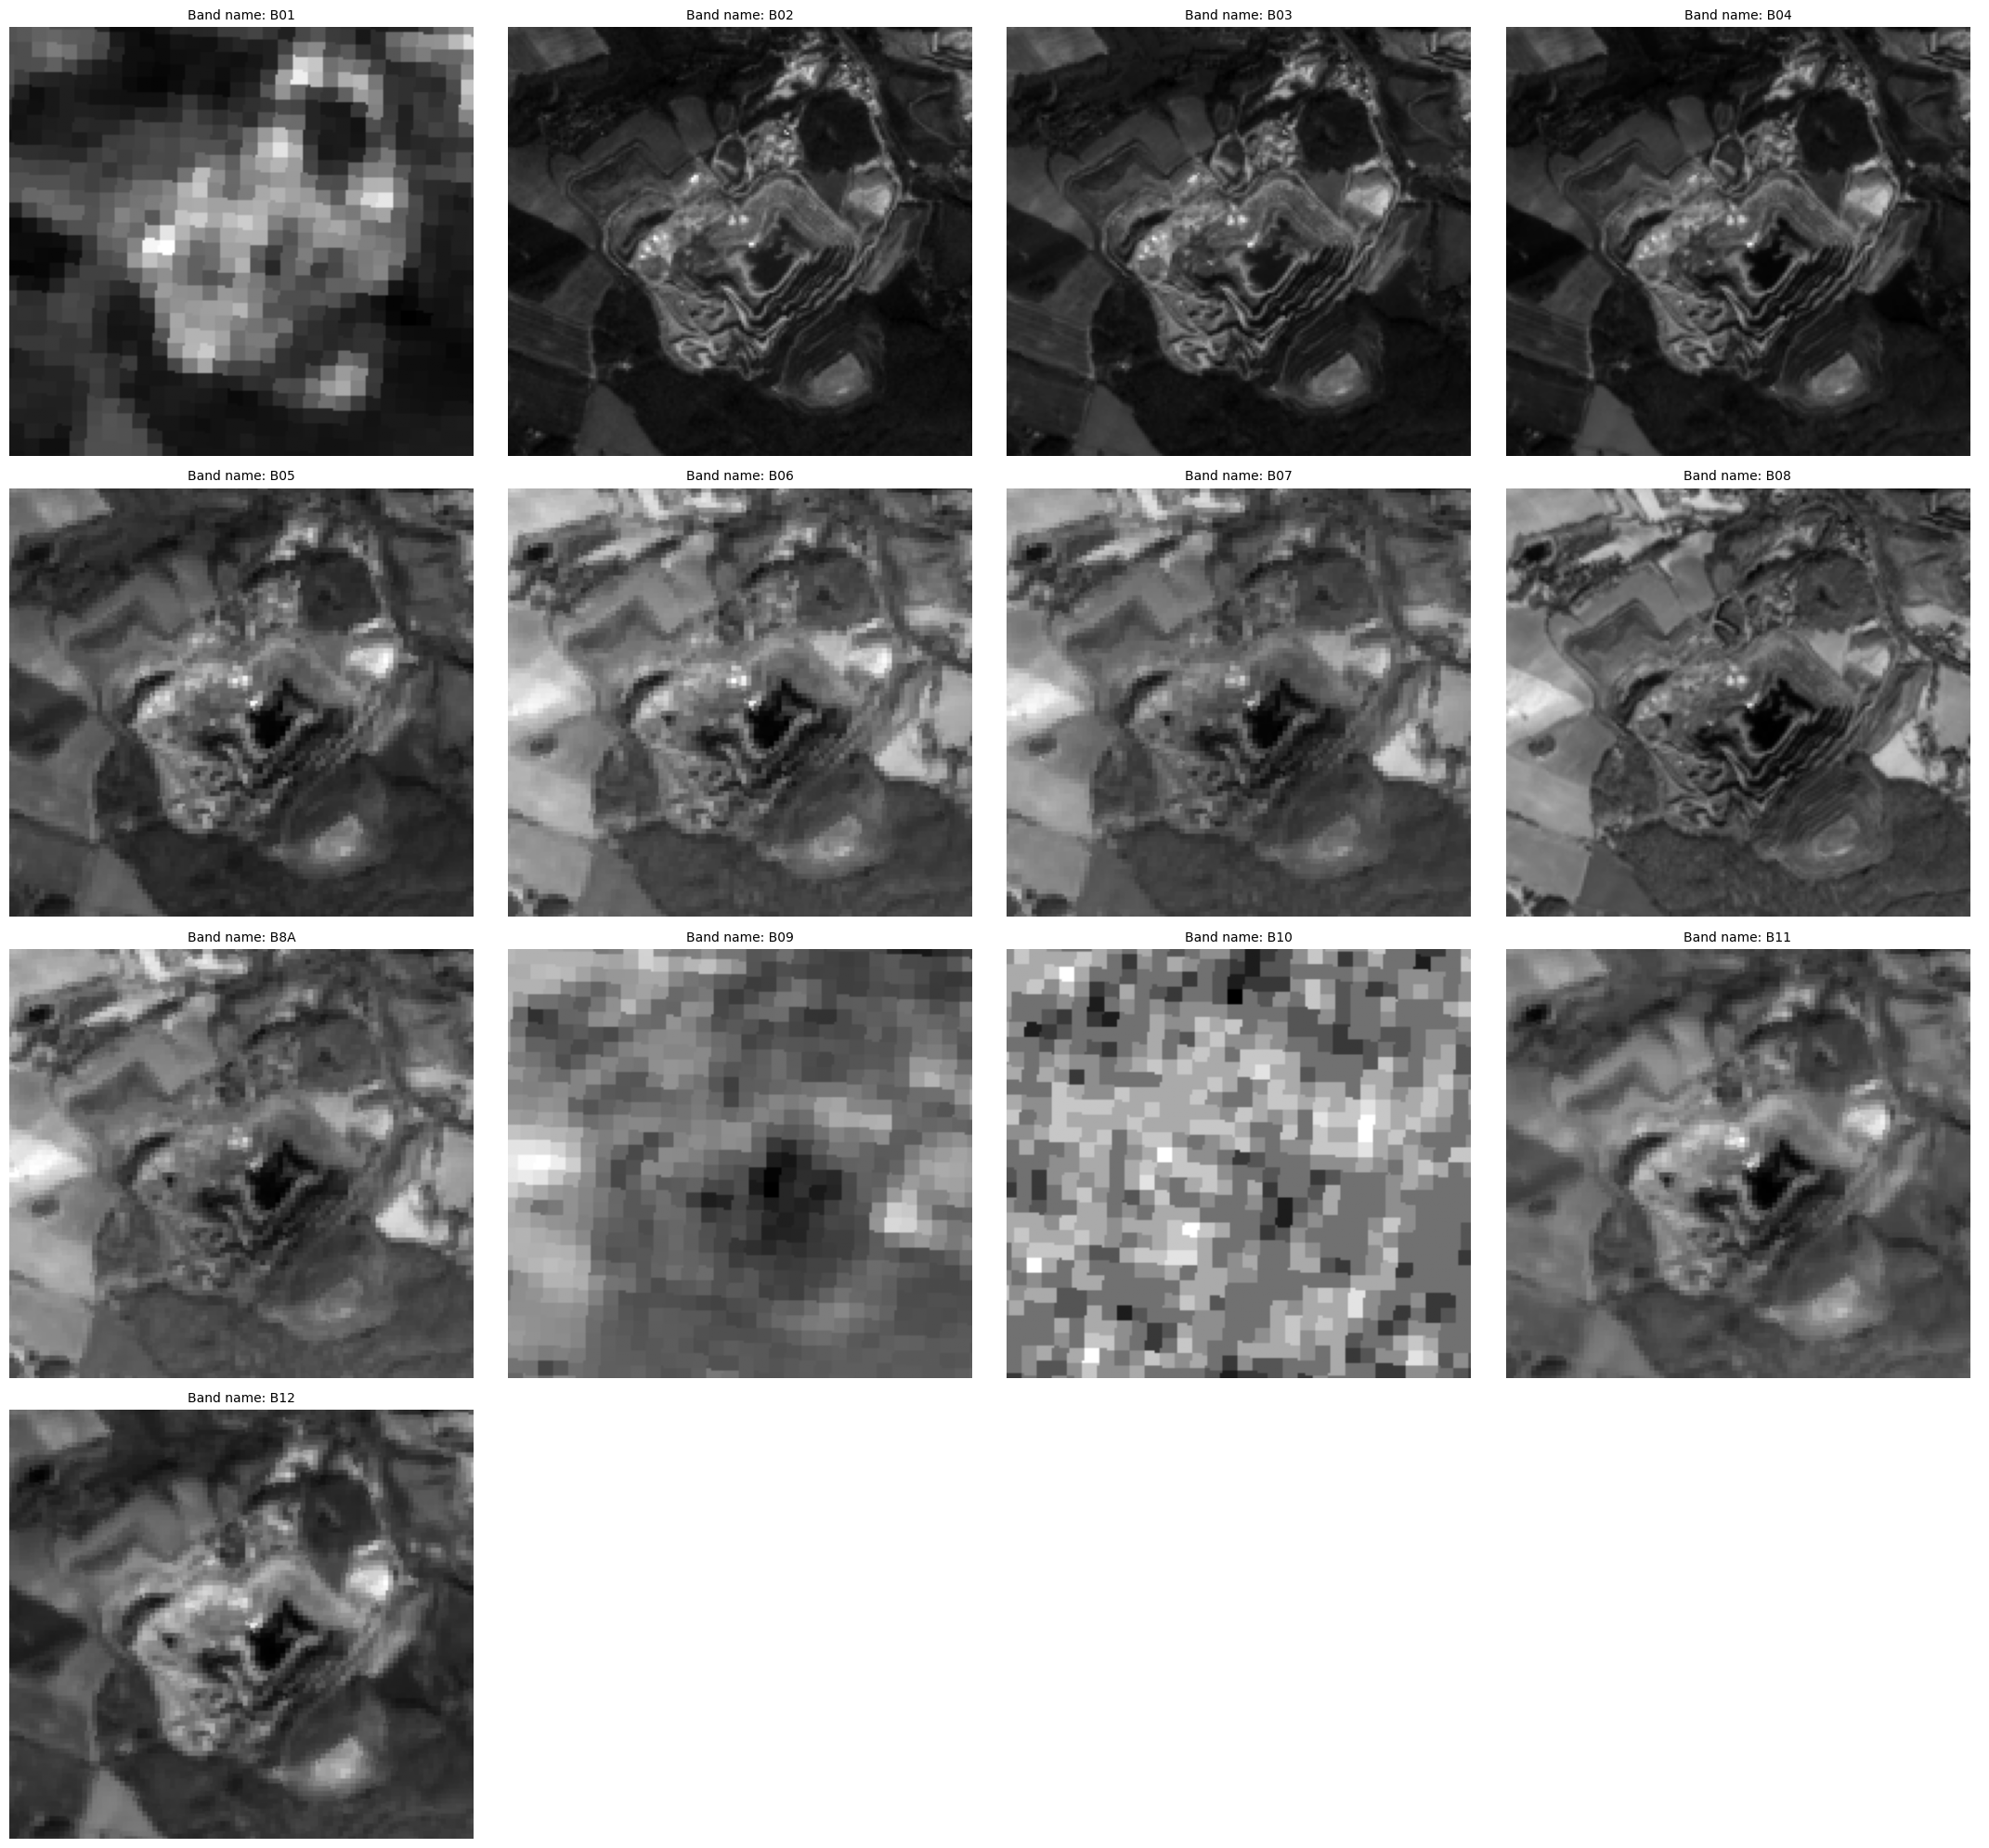

In [10]:
# Some stuff for pretty plots
ncols = 4
nrows = 4
aspect_ratio = oetelshofen_size[0] / oetelshofen_size[1]
subplot_kw = {"xticks": [], "yticks": [], "frame_on": False}

# Load the information for the different bands
with open(REFERENCES_DIR / 'SENTINEL2_L1C_bands.yaml') as infile:
    band_info = yaml.load(infile, Loader=yaml.FullLoader)

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols * aspect_ratio, 5 * nrows), subplot_kw=subplot_kw)

for i in range(13):
    image = all_bands_response[0][:, :, i]
    ax = axs[i // ncols][i % ncols]
    ax.imshow(np.clip(image * 2 / 1e4, 0, 1), cmap="grey")
    ax.set_title(f"Band name: {band_info[i]['band name']}", fontsize=10)

plt.tight_layout()

In [11]:
# Here are the highest resolution bands, with a 10m resolution
for i in range(13):
    if band_info[i]["resolution"] == "10":
        print(band_info[i])

{'band name': 'B02', 'description': 'Blue, 492.4 nm (S2A), 492.1 nm (S2B)', 'resolution': '10'}
{'band name': 'B03', 'description': 'Green, 559.8 nm (S2A), 559.0 nm (S2B)', 'resolution': '10'}
{'band name': 'B04', 'description': 'Red, 664.6 nm (S2A), 665.0 nm (S2B)', 'resolution': '10'}
{'band name': 'B08', 'description': 'NIR, 832.8 nm (S2A), 833.0 nm (S2B)', 'resolution': '10'}


In [12]:
# Here are the medium resolution bands, with a 20m resolution
for i in range(13):
    if band_info[i]["resolution"] == "20":
        print(band_info[i])

{'band name': 'B05', 'description': 'Vegetation red edge, 704.1 nm (S2A), 703.8 nm (S2B)', 'resolution': '20'}
{'band name': 'B06', 'description': 'Vegetation red edge, 740.5 nm (S2A), 739.1 nm (S2B)', 'resolution': '20'}
{'band name': 'B07', 'description': 'Vegetation red edge, 782.8 nm (S2A), 779.7 nm (S2B)', 'resolution': '20'}
{'band name': 'B8A', 'description': 'Narrow NIR, 864.7 nm (S2A), 864.0 nm (S2B)', 'resolution': '20'}
{'band name': 'B11', 'description': 'SWIR, 1613.7 nm (S2A), 1610.4 nm (S2B)', 'resolution': '20'}
{'band name': 'B12', 'description': 'SWIR, 2202.4 nm (S2A), 2185.7 nm (S2B)', 'resolution': '20'}


In [13]:
# Here are the low resolution bands, with a 60m resolution
for i in range(13):
    if band_info[i]["resolution"] == "60":
        print(band_info[i])

{'band name': 'B01', 'description': 'Coastal aerosol, 442.7 nm (S2A), 442.3 nm (S2B)', 'resolution': '60'}
{'band name': 'B09', 'description': 'Water vapour, 945.1 nm (S2A), 943.2 nm (S2B)', 'resolution': '60'}
{'band name': 'B10', 'description': 'SWIR - Cirrus, 1373.5 nm (S2A), 1376.9 nm (S2B)', 'resolution': '60'}


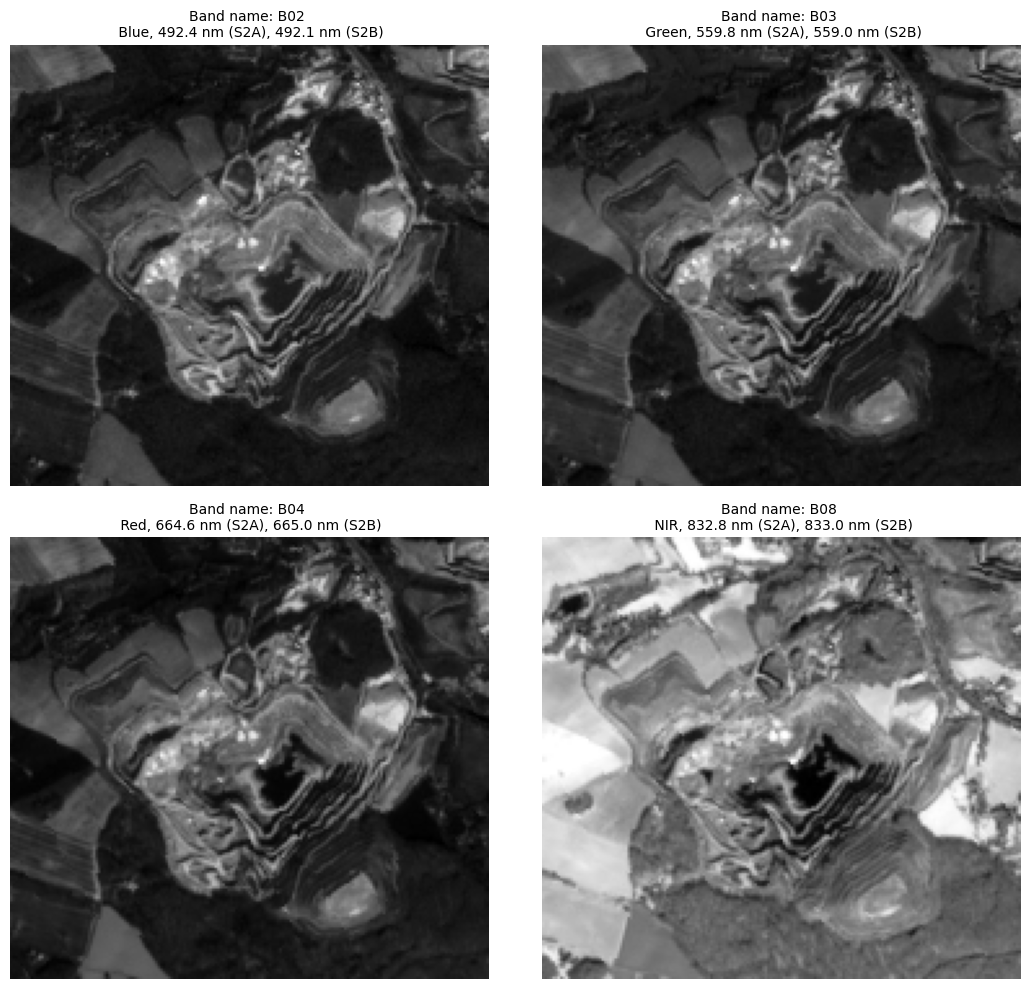

In [14]:
# Let's just plot the high-resolution images

# Some stuff for pretty plots
ncols = 2
nrows = 2
aspect_ratio = oetelshofen_size[0] / oetelshofen_size[1]
subplot_kw = {"xticks": [], "yticks": [], "frame_on": False}

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols * aspect_ratio, 5 * nrows), subplot_kw=subplot_kw)

j = 0
for i in range(13):
    if band_info[i]["resolution"] == "10":
        image = all_bands_response[0][:, :, i]
        ax = axs[j // ncols][j % ncols]
        ax.imshow(np.clip(image * 2.5 / 1e4, 0, 1), cmap="Greys_r")
        ax.set_title(f"Band name: {band_info[i]['band name']} \n {band_info[i]['description']}", fontsize=10)
        j += 1
plt.tight_layout()

Let's plot standard combinations of the high-resolution bands.

In [15]:

#Renaming the images will be useful
red_band = all_bands_response[0][:, :, [3]]
green_band = all_bands_response[0][:, :, [2]]
blue_band = all_bands_response[0][:, :, [1]]
NIR_band = all_bands_response[0][:, :, [7]]

B8_band = all_bands_response[0][:, :, [7]]
B8A_band = all_bands_response[0][:, :, [8]]
B11_band = all_bands_response[0][:, :, [11]]


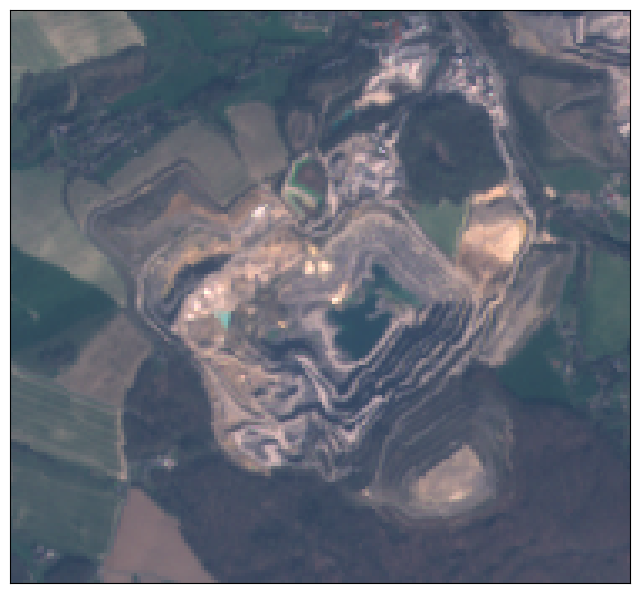

In [16]:
# True colour: RGB -> RGB
# Product with natural colours that represents the Earth as humans would naturally see it.

# R = B04 (Red, 664.6 nm (S2A), 665.0 nm (S2B))
# G = B03 (Green, 559.8 nm (S2A), 559.0 nm (S2B))
# B = B02 (Blue, 492.4 nm (S2A), 492.1 nm (S2B))

plot_image(all_bands_response[0][:, :, [3, 2, 1]], factor=3.5 / 1e4, clip_range=(0, 1), figsize=(8,8))

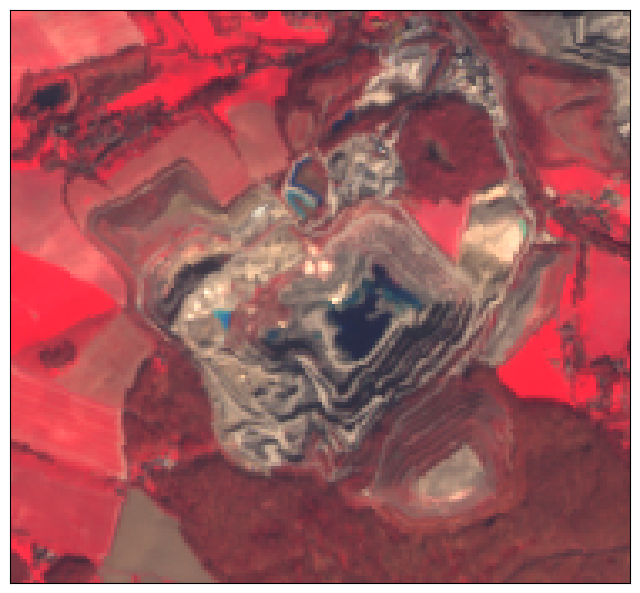

In [17]:
# False colour: NRG -> RGB
# The false colour composite is most commonly used to assess plant density and health,
# since plants reflect near infrared and green light, while they absorb red. Cities
# and exposed ground are grey or tan, and water appears blue or black.

# R = B08 (NIR, 832.8 nm (S2A), 833.0 nm (S2B))
# G = B04 (Red, 664.6 nm (S2A), 665.0 nm (S2B))
# B = B03 (Green, 559.8 nm (S2A), 559.0 nm (S2B))

plot_image(all_bands_response[0][:, :, [7, 3, 2]], factor=3 / 1e4, clip_range=(0, 1), figsize=(8,8))

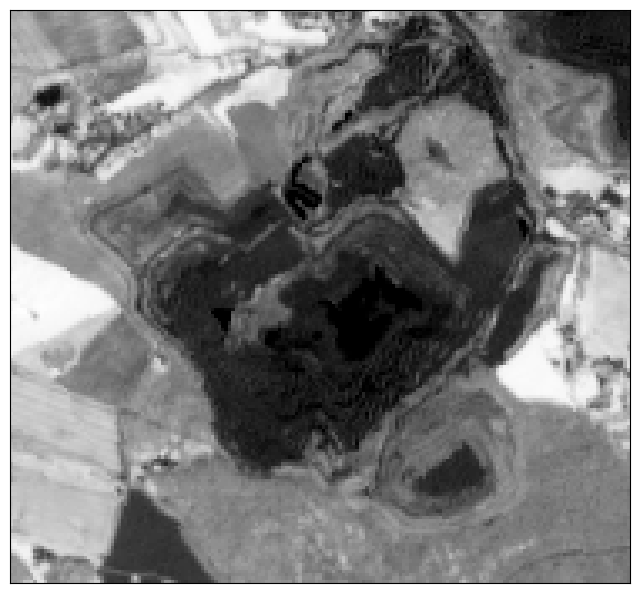

In [18]:
# NDVI: (N - R) / (N + R)
# The normalized difference vegetation index is a simple, but effective index
# for quantifying green vegetation. It is a measure of the state of vegetation
# health based on how plants reflect light at certain wavelengths.

ndvi_image = (NIR_band - red_band)/(NIR_band + red_band)

plot_image(ndvi_image, factor=3 / 1e4, clip_range=(0, 1), cmap="Greys_r", figsize=(8,8))

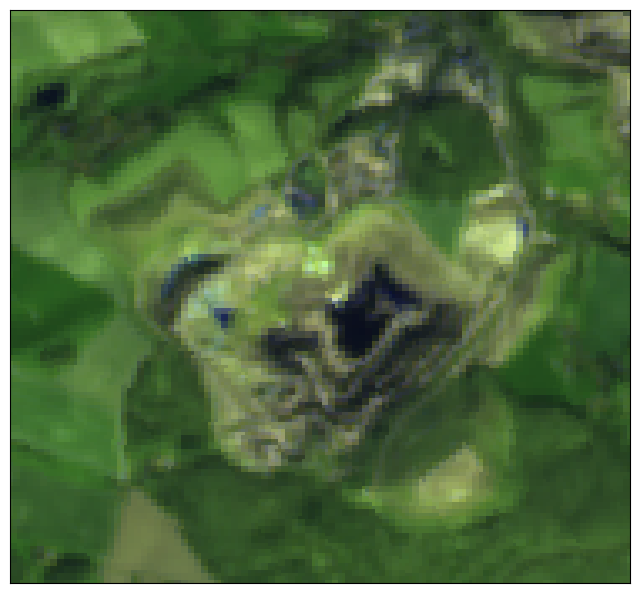

In [19]:
# False colour (urban): B12 B11 R -> RGB
# This composite is used to visualize urbanized areas more clearly. Vegetation is
# visible in shades of green, while urbanized areas are represented by white,
# grey, or purple. Soils, sand, and minerals are shown in a variety of colors.
# Snow and ice appear as dark blue, and water as black or blue. Flooded areas
# are very dark blue and almost black. The composite is useful for detecting wildfires
# and calderas of volcanoes, as they are displayed in shades of red and yellow.

# R = B12 (SWIR, 2202.4 nm (S2A), 2185.7 nm (S2B))
# G = B11 (SWIR, 1613.7 nm (S2A), 1610.4 nm (S2B))
# B = B4 (Red, 664.6 nm (S2A), 665.0 nm (S2B))

plot_image(all_bands_response[0][:, :, [12, 11, 3]], factor=2 / 1e4, clip_range=(0, 1), figsize=(8,8))

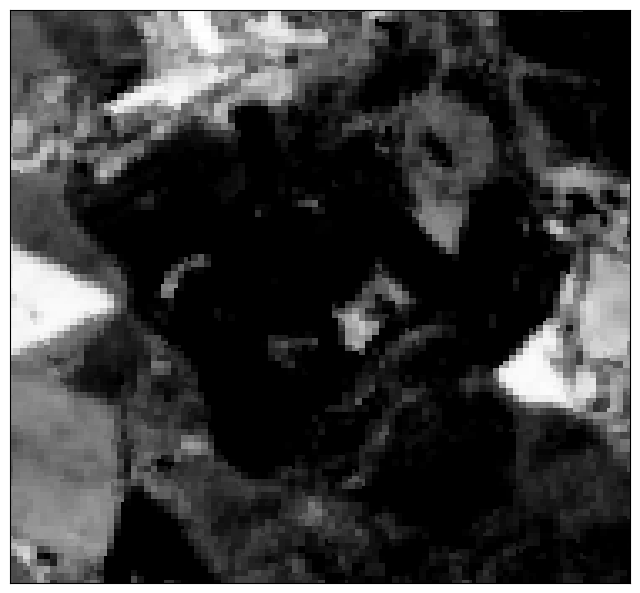

In [20]:
# Moisture index: (B8A - B11) / (B8A + B11)
# The normalized difference moisture Index (NDMI) is used to
# determine vegetation water content and monitor droughts.



moisture_index_image = ndvi_image = (B8A_band - B11_band)/(B8A_band + B11_band)

plot_image(moisture_index_image, factor= 2 / 1e4, clip_range=(0, 1), cmap="Greys_r", figsize=(8,8))

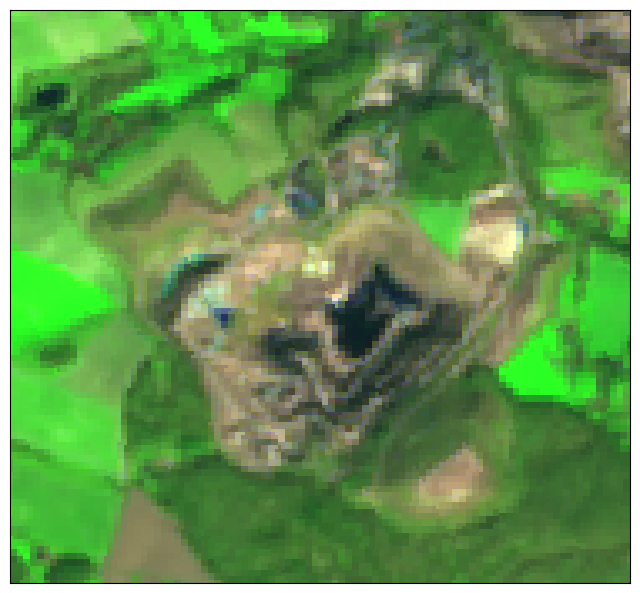

In [21]:
# SWIR: B12 B8A R -> RGB
# Short wave infrared (SWIR) measurements can help scientists estimate
# how much water is present in plants and soil, as water absorbs SWIR wavelengths.

# R = B12 SWIR, 2202.4 nm (S2A), 2185.7 nm (S2B)
# G = B8A Narrow NIR, 864.7 nm (S2A), 864.0 nm (S2B)
# B = B04 (Red, 664.6 nm (S2A), 665.0 nm (S2B))

plot_image(all_bands_response[0][:, :, [12, 8, 3]], factor=2.5 / 1e4, clip_range=(0, 1), figsize=(8,8))


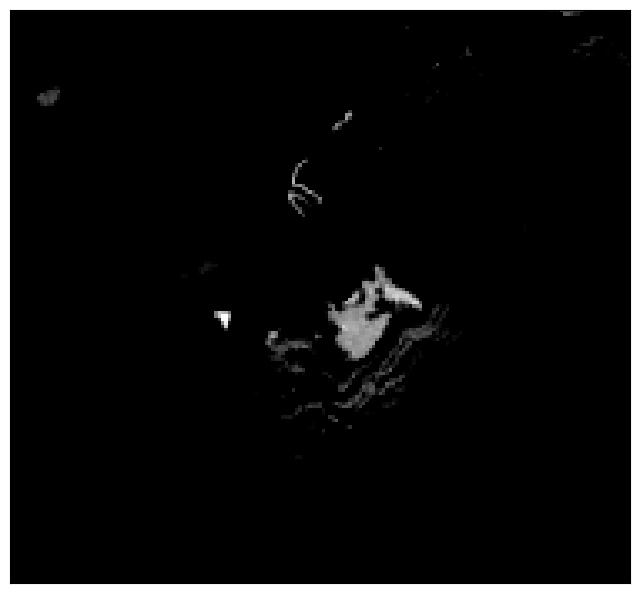

In [22]:
# NDWI: (B3 - B8)/(B3 + B8)
# The normalized difference water index is most appropriate for water body mapping.


ndwi_image = (green_band - B8_band)/(green_band + B8_band)

plot_image(ndwi_image, factor= 3 / 1e4, clip_range=(0, 1), cmap="Greys_r", figsize=(8,8))

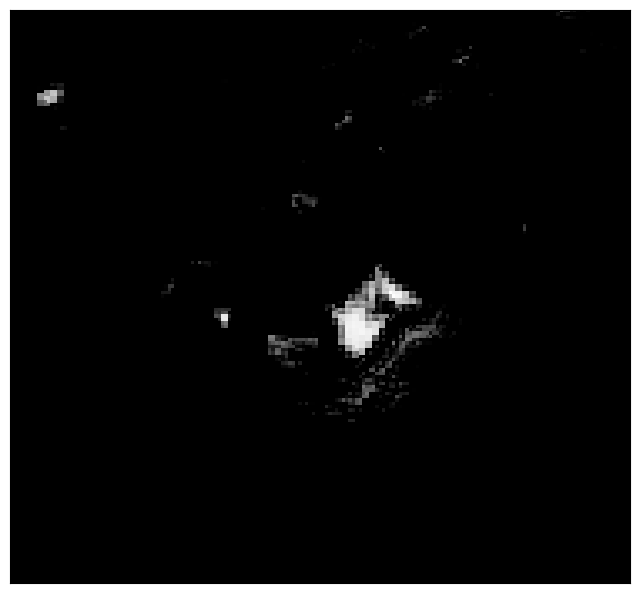

In [23]:
# NDSI (B3 - B11)/(B3 + B11)
# The Sentinel-2 normalised difference snow index can be used to differentiate
# between cloud and snow cover as snow absorbs in the short-wave infrared light,
# but reflects the visible light, whereas cloud is generally reflective in both
# wavelengths. Snow cover is represented in bright vivid blue.

ndsi_image = (green_band - B11_band)/(green_band + B11_band)

plot_image(ndsi_image, factor= 3 / 1e4, clip_range=(0, 1), cmap="Greys_r", figsize=(8,8))